In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [14]:
def build_iris(path):
    data = open(path)
    label_list = []
    features_list = []
    feild_list = []
    for line in data.readlines():
        feature_label = line.strip().split(',')
        label_list.append(int(feature_label[-1]))
        features = list(map(lambda x: float(x), feature_label[0:-1]))
        features_list.append(features)
        feild_list.append([0, 1, 2, 3])

    features_train = np.array(features_list).reshape([100, 4])
    feild_of_train = np.array(feild_list).reshape([100, 4])
    label_train = np.array(label_list).reshape([100, 1])
    return label_train, features_train, feild_of_train

In [30]:
def model(x, feild, n, k):
    
    # fm part
    
    w = tf.Variable(tf.truncated_normal([n, 1], stddev=0.1), name='w')
    v = tf.Variable(tf.truncated_normal([n, k], stddev=0.1), name='v')
    temp_1 = tf.matmul(x, v)
    temp_2 = tf.matmul(tf.square(x), tf.square(v))
    interaction = tf.multiply(0.5, tf.reduce_sum(tf.multiply(temp_1, temp_1) - temp_2, 1, keepdims=True))
    fm_part = tf.matmul(x, w) + interaction
    
    # deep part
    input_size = n * k
    
    layer_0 = tf.Variable(tf.truncated_normal([input_size, 256], stddev=0.1), name='layer_0')
    bias_0 = tf.Variable(tf.truncated_normal([1, 256], stddev=0.1), name='bias_0')
    layer_1 = tf.Variable(tf.truncated_normal([256, 128], stddev=0.1), name='layer_1')
    bias_1 = tf.Variable(tf.truncated_normal([1, 128], stddev=0.1), name='bias_1')
    layer_2 = tf.Variable(tf.truncated_normal([128, 64], stddev=0.1), name='layer_2')
    bias_2 = tf.Variable(tf.truncated_normal([1, 64], stddev=0.1), name='bias_2')
    
    index = tf.nn.embedding_lookup(v, feild)
    embedding_start = tf.multiply(index, tf.reshape(x, [-1, n, 1]))
    embedding_start = tf.reshape(embedding_start, [-1, input_size])
    embedding = tf.add(tf.matmul(embedding_start, layer_0), bias_0)
    embedding = tf.add(tf.matmul(embedding, layer_1), bias_1)
    embedding = tf.add(tf.matmul(embedding, layer_2), bias_2)
    embedding = tf.nn.relu(embedding)
    
    # last layer of all parts
    last_layer_size = 64 + 1
    last_layer = tf.Variable(tf.truncated_normal([last_layer_size, 1], stddev=0.1), name='last_layer')
    last_bias = tf.Variable([0.01], trainable=True, name='last_bias')
    din_all = tf.concat([fm_part, embedding], axis=1)
    output = tf.add(tf.matmul(din_all, last_layer), last_bias)

    return output


def loss_func(output, y, train_type):
    if train_type == 'regr':
        loss = tf.reduce_mean(tf.square(output - y))
    elif train_type == '2_class':
        loss = -tf.reduce_sum(tf.log(tf.sigmoid(tf.multiply(output, y))))
    return loss


def training(loss, learning_rate):
    train = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return train


def run(x, feild, y, learning_rate, epoch, n, k, train_type, x_train_data, feild_of_x, y_train_data):
    
    feed_dict = {x: x_train_data, feild: feild_of_x, y: y_train_data, }
    with tf.Session() as sess:
        output = model(x, feild, n, k)
        loss = loss_func(output, y, train_type)
        train = training(loss, learning_rate)
        
        init = tf.global_variables_initializer()
        sess.run(init)
        for i in range(epoch):
            sess.run(train, feed_dict=feed_dict)
            loss_results = sess.run(loss, feed_dict=feed_dict)
            loss_list.append(loss_results)
            if i % (epoch/10) == 0:
                print('step[{}]  loss : {}'.format(i, loss_results))
        y_results = sess.run(output, feed_dict=feed_dict)
        if train_type == 'regr':
            plot_graph(x_train_data, y_train_data, y_results)
        elif train_type == '2_class':
            acc = 0
            for i in range(len(y_results)):
                if y_results[i][0] > 0:
                    y_test = 1
                else:
                    y_test = -1
                if y_train_data[i] == y_test:
                    acc += 1
            print("accuracy:", acc / 100.0)
            plt.plot(loss_list)
            plt.show()
            

def plot_graph(x_train_data, y_train_data, y_results):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
    ax1.plot(x_train_data, y_results, color='red',)
    ax1.plot(x_train_data, y_train_data, color='blue')
    ax2.set_ylabel('loss')
    ax2.plot(loss_list)
    plt.show()

step[0]  loss : 85.60015106201172
step[5]  loss : 4.099395751953125
step[10]  loss : 0.0007964229444041848
step[15]  loss : 2.5987825210904703e-05
step[20]  loss : 2.264978093080572e-06
step[25]  loss : 2.3841860752327193e-07
step[30]  loss : 1.1920928955078125e-07
step[35]  loss : -0.0
step[40]  loss : -0.0
step[45]  loss : -0.0
accuracy: 1.0


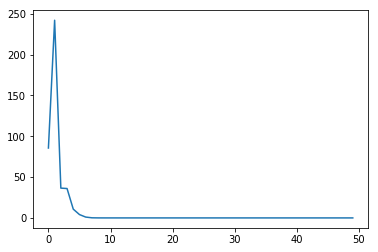

In [32]:
label_train, features_train, feild_of_train = build_iris("./data/iris_2class.txt")
learning_rate = 0.01
epoch = 50
loss_list = []
x = tf.placeholder(shape=[None, 4], dtype=tf.float32)
feild = tf.placeholder(shape=[None, 4], dtype=tf.int32)
y = tf.placeholder(shape=[None, 1], dtype=tf.float32)
run(x, feild, y, learning_rate, epoch, 4, 30, '2_class', features_train, feild_of_train, label_train)